# Homework 3  - Part B


###### Roll Number:

In [0]:
21020572

21020572

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

!mkdir images

!unzip "/content/drive/My Drive/cifar.zip" -d images/

Streaming output truncated to the last 5000 lines.
  inflating: images/cifar/train/550_cat.png  
  inflating: images/cifar/train/5510_dog.png  
  inflating: images/cifar/train/5511_truck.png  
  inflating: images/cifar/train/5512_automobile.png  
  inflating: images/cifar/train/5513_frog.png  
  inflating: images/cifar/train/5514_deer.png  
  inflating: images/cifar/train/5515_automobile.png  
  inflating: images/cifar/train/5516_airplane.png  
  inflating: images/cifar/train/5517_dog.png  
  inflating: images/cifar/train/5518_horse.png  
  inflating: images/cifar/train/5519_truck.png  
  inflating: images/cifar/train/551_horse.png  
  inflating: images/cifar/train/5520_cat.png  
  inflating: images/cifar/train/5521_airplane.png  
  inflating: images/cifar/train/5522_frog.png  
  inflating: images/cifar/train/5523_ship.png  
  inflating: images/cifar/train/5524_truck.png  
  inflating: images/cifar/train/5525_horse.png  
  inflating: images/cifar/train/5526_frog.png  
  inflating: imag

In [0]:
!mkdir log

mkdir: cannot create directory ‘log’: File exists


We'll start Part B by taking out a minute to thank creators of Tensorflow and Keras for making our lives easier. The goal of this home work is to design a convolutional neural network to classify images from CIFAR-10. CIFAR-10 is a subset of CIFAR-100 with 10 and 100 being number of classes. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. We'll be building small CNNs using Keras to solve this classification task.
<br>

Please note:
- You have to save each trained model weights and tensorboard logs in different folder. Use proper names for the model
- You have to show trainings in this notebook file, so make sure that the printings and figures are available on this notebook file
- This notebook is also your report file. So add your comments and analysis of each task. Your comments and analysis are as important as your code. This would be considered short report and it is compulsory part of the homework.
- Your system memory may overflow. In that case, please reset memory for trained model(s) keeping printed logs and history of trained model. History of all trained models could be used to plot the trends.
- For trends you shall also use tensorboard logs 

### Imports

In [0]:
import keras
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard
from keras.utils import plot_model, to_categorical
import keras.backend as K

from sklearn.model_selection import train_test_split
from IPython.display import display

import random
import cv2
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import os
import glob
your_id = 21020572
np.random.seed(your_id)

Using TensorFlow backend.


###### Hyperparameters

In [0]:
batch_size = 64
num_classes = 10
class_labels = np.arange(0, num_classes, 1)
input_shape_cifar = (32,32,3)
images_dir = 'images/cifar/'
epochs = 8
all_histories = []

### Task 1.1   Load dataset information
Download the [CIFAR-10 Dataset](https://drive.google.com/drive/folders/1FPsts3C2tJMVQ1xcCi2XZdb2z_J2OjSr?usp=sharing) and setup your working directory. Be sure to put the dataset in the <code>images_dir</code> directory. We won't be loading images and will only store the file paths in memory. These file paths will be used to load and return batch of images in our generator. Feel free to explore the dataset in this section.

In [0]:
train_dir = images_dir + 'train/'
test_dir = images_dir + 'test/'
label_dir = images_dir + 'labels.txt'

# Use either os.listdir or glob to generate an array of file paths for training and testing data (I would recommend using glob)
train_files = glob.glob(train_dir+"*")
test_files = glob.glob(test_dir+"*")

# Use labels.txt to store labels in an array/dict (NOTE: The line number corresponds to the actual label)
#classes = [line.rstrip('\n') for line in open(label_dir)]
classes = {}
class_help = open(label_dir, 'r').read().split('\n')
for x in class_labels:
  classes[class_help[x]] = x
# Use sci-kit learn's train_test_split method to generate a validation dataset from the training dataset
val_files = train_test_split(train_files)[0]

### Task 1.2 Preprocessing
Preprocessing of data such as normalization, mean shift, make the learning task simple for network and could accelerate the training process. 

###### Task 1.2.1 
In images, pixel values range from 0 to 255. To shift the values between (0,1) range, divide input image by 255.

In [0]:
def preprocessing_norm(images):
    return [x / 255.0 for x in images]

###### Task 1.2.2
Compute the channel-wise mean and standard deviation (std). Subtract channel-wise mean and divide by channel-wise std. This will shift the mean to zero and variation to 1 for each channel. 

In [0]:
def preprocessing_meanShift(images):
    for i in images:
      for r in range(3):
        i[:,:,r] = (i[:,:,r] - np.mean(i[:,:,r])) / np.std(i[:,:,r])

### Task 1.3  Batch Generator
Previously, when training our models, we were loading the complete data in memory to fit our model. However, in practice we're working with very large datasets which cannot be loaded all at once in memory. As a solution, we use "Data Generators" which are essentially python generators that load batches of data from disk into memory and pass into our models. In order to achieve this, we only store filepaths that point to training/test samples in our dataset in memory. A data generator yields a tuple of (Xs,Ys) whenever the generator is used via the next() function. Implementation of a data generator is open ended, you can add whatever arguments you find necessary in addition to the ones provided.

In [0]:
def data_generator( paths , batch_size = 32, preprocessing = lambda x:x):
    while True:
      random.shuffle(paths)
      for x in range(len(paths)//batch_size):      
        pat = paths[x*batch_size:(x+1)*batch_size]
        yield (np.array([preprocessing(cv2.imread(x)) for x in pat]),np.array([classes[x.split("_")[1].split(".")[0]] for x in pat]))

### Task 1.4 Design CNN model
**IMPORTANT**: For each model you create, you need to conduct analysis in a markdown cell below the code cell containing the model's training. Your analysis should include plots, comments on its accuracy/loss, etc. Try to predict images and see what images your model is correctly classifying, see if your model is overfitting or not. For each layer you add, specify its function and then comment on its results.

In [0]:
# Design a CNN to predict classes for the images in the dataset. Try to keep your network shallow since you'll be training your model on your PC as well.
input_img = Input(shape=(input_shape_cifar), name='input_img')
convol = Conv2D(32,(2,2),input_shape=input_shape_cifar,activation='relu')(input_img)
convoll = Conv2D(32,(2,2),activation='relu')(convol)
convolll = Conv2D(64,(2,2),activation='relu')(convoll)
flat = Flatten()(convoll)
dense = Dense(64,activation="relu")(flat)
densee = Dense(10,activation="softmax")(dense)
model_initial = Model(input_img,densee)

#### Compile model and plot

In [0]:
model_name = 'base_model'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [0]:
 # You may tweak the learning rate
adam = Adam(lr=0.001)
# Use the appropriate loss function and compile the model
model_initial.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam, 
              metrics=['accuracy'])

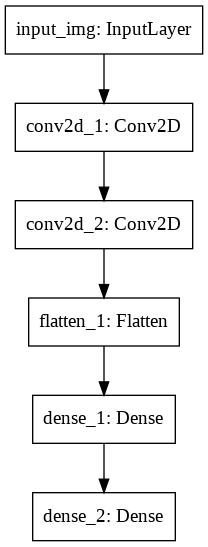

In [0]:
plot_model(model_initial, model_name+'/'+model_name+'.png')

In [0]:
model_initial.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 31, 32)        416       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        4128      
_________________________________________________________________
flatten_1 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1843264   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 1,848,458
Trainable params: 1,848,458
Non-trainable params: 0
_________________________________________________

#### Task 1.5 Training model
In order to train the model, instead of "model.fit" function, we will use the "model.fit_generator" function for training. For details check out [keras documentation](https://keras.io/models/sequential/)

In [0]:
class LRTensorBoard(TensorBoard):
    def __init__(self, *args, **kwargs):
        super(LRTensorBoard, self).__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super(LRTensorBoard, self).on_epoch_end(epoch, logs)

In [0]:
# Add the following callbacks to your Model: ModelCheckpoin, CSVLogger, ReduceLROnPlateau. The callback for Tensorboard has already been provided to you.
checkpoint = ModelCheckpoint('./'+model_name+'/a.m', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
csvlogger = CSVLogger('./log/'+model_name + '.log', separator=',', append=False)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)
callbacks = [checkpoint,csvlogger,reducelr,tensorboard]

#### Task 1.5.1 
Train model without using any pre-processing scheme

In [0]:
# Create three generators: For training your model, for validation, for testing.
train = data_generator(train_files,batch_size=batch_size)
test = data_generator(test_files,batch_size=batch_size)
val = data_generator(val_files,batch_size=batch_size)

In [0]:
# Start training your model here
history = model_initial.fit_generator(train, callbacks=callbacks, validation_data=val,epochs=epochs,steps_per_epoch=len(train_files) // batch_size,validation_steps=len(val_files) // batch_size)

all_histories.append(history)

Epoch 1/8
778/781 [============================>.] - ETA: 0s - loss: 14.5064 - acc: 0.1000

KeyboardInterrupt: ignored

#### Task 1.5.2 
Train model by using data preprocessing i.e normalization or mean shift. 

In [0]:
image = Input(shape=(input_shape_cifar), name='input_img')
convol = Conv2D(32,(2,2),input_shape=input_shape_cifar,activation='relu')(image)
convoll = Conv2D(32,(2,2),activation='relu')(convol)
convolll = Conv2D(64,(2,2),activation='relu')(convoll)
flat = Flatten()(convoll)
dense = Dense(64,activation="relu")(flat)
densee = Dense(10,activation="softmax")(dense)
model_preprocessed = Model(image,densee)

In [0]:
model_name = 'model_preprocessed_input'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [0]:
# You may tweak this Learning Rate
adam = Adam(lr=0.00001)
# Compile your model using an appropriate loss
model_preprocessed.compile(loss="sparse_categorical_crossentropy", 
              optimizer=adam, 
              metrics=['accuracy'])

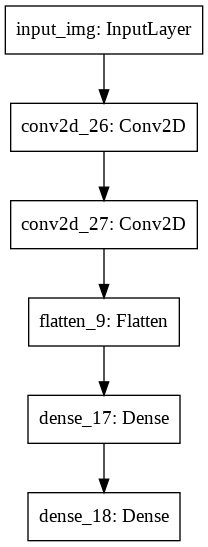

In [0]:
plot_model(model_preprocessed, model_name+'/'+model_name+'.png')

In [0]:
model_preprocessed.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 31, 31, 32)        416       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 30, 30, 32)        4128      
_________________________________________________________________
flatten_9 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                1843264   
_________________________________________________________________
dense_18 (Dense)             (None, 10)                650       
Total params: 1,848,458
Trainable params: 1,848,458
Non-trainable params: 0
_________________________________________________

In [0]:
# Add the following callbacks: ModelCheckpoint, CSVLogger. The callback for tensorboard has been provided to you.
checkpoint = ModelCheckpoint('./'+model_name+'/a.m', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
csvlogger = CSVLogger('./log/'+model_name + '.log', separator=',', append=False)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)
callbacks = [checkpoint,csvlogger,tensorboard]

In [0]:
# Create three generators again
train = data_generator(train_files,batch_size=batch_size,preprocessing=preprocessing_norm)
test = data_generator(test_files,batch_size=batch_size,preprocessing=preprocessing_norm)
val = data_generator(val_files,batch_size=batch_size,preprocessing=preprocessing_norm)

In [0]:
history2 = model_preprocessed.fit_generator(train, callbacks=callbacks, validation_data=val,epochs=epochs,steps_per_epoch=len(train_files) // batch_size,validation_steps=len(val_files) // batch_size)
all_histories.append(history2)

Epoch 1/8
781/781 [==============================] - 18s 23ms/step - loss: 2.0788 - acc: 0.2828 - val_loss: 1.8918 - val_acc: 0.3603
Epoch 2/8
781/781 [==============================] - 18s 23ms/step - loss: 1.8030 - acc: 0.3848 - val_loss: 1.7332 - val_acc: 0.4011
Epoch 3/8
781/781 [==============================] - 18s 23ms/step - loss: 1.6843 - acc: 0.4225 - val_loss: 1.6438 - val_acc: 0.4328
Epoch 4/8
781/781 [==============================] - 18s 23ms/step - loss: 1.6046 - acc: 0.4473 - val_loss: 1.5692 - val_acc: 0.4601
Epoch 5/8
781/781 [==============================] - 18s 23ms/step - loss: 1.5425 - acc: 0.4669 - val_loss: 1.5179 - val_acc: 0.4721
Epoch 6/8
781/781 [==============================] - 18s 23ms/step - loss: 1.4960 - acc: 0.4824 - val_loss: 1.4737 - val_acc: 0.4902
Epoch 7/8
781/781 [==============================] - 18s 23ms/step - loss: 1.4599 - acc: 0.4932 - val_loss: 1.4418 - val_acc: 0.5013
Epoch 8/8
781/781 [==============================] - 18s 23ms/step - 

In [0]:
print(all_histories)

[<keras.callbacks.History object at 0x7ff4ad1b4a90>, <keras.callbacks.History object at 0x7ff4acfb5240>, <keras.callbacks.History object at 0x7ff4ac5ba7f0>]


### Task 2.1 Pooling
Now, you need to modify the model by adding pooling layer(s). Pooling could be average pooling or max pooling. You can use the size and stride for pooling of your choice. 
<br> 
Modify the network by introducing pooling layer and train the model using the __fit_generator__ function. 

In [0]:
model_name = 'model_pooling'
input_img = Input(shape=(input_shape_cifar), name='input_img')
convol = Conv2D(32,(2,2),input_shape=input_shape_cifar,activation='relu')(input_img)
pol= MaxPooling2D((3,3),2)(convol)
convoll = Conv2D(32,(2,2),activation='relu')(pol)
pool = MaxPooling2D((3,3),2)(convoll)
convolll = Conv2D(64,(2,2),activation='relu')(pool)
poool=MaxPooling2D((3,3),2)(convolll)
flat= Flatten()(convoll)
dense= Dense(64,activation="relu")(flat)
densee = Dense(10,activation="softmax")(dense)
model_pooled = Model(input_img,densee)
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [0]:
adam = Adam(lr=0.001)
model_pooled.compile(loss="sparse_categorical_crossentropy", 
              optimizer=adam, 
              metrics=['accuracy'])

In [0]:

plot_model(model_pooled, model_name+'/'+model_name+'.png')
model_pooled.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 31, 31, 32)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        4128      
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                401472    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650 

In [0]:
# Add the following callbacks: ModelCheckpoint, CSVLogger
checkpoint = ModelCheckpoint('./'+model_name+'/a.m', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
csvlogger = CSVLogger('./log/'+model_name + '.log', separator=',', append=False)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)
callbacks = [checkpoint,csvlogger,tensorboard]

In [0]:
# Create generators
train = data_generator(train_files,batch_size=batch_size,preprocessing=preprocessing_norm)
test = data_generator(test_files,batch_size=batch_size,preprocessing=preprocessing_norm)
val = data_generator(val_files,batch_size=batch_size,preprocessing=preprocessing_norm)

In [0]:
historyPooled = model_pooled.fit_generator(train, callbacks=callbacks, validation_data=val,epochs=epochs,steps_per_epoch=len(train_files) // batch_size,validation_steps=len(val_files) // batch_size)
all_histories.append(historyPooled)

Epoch 1/8
781/781 [==============================] - 17s 22ms/step - loss: 1.4851 - acc: 0.4706 - val_loss: 1.2046 - val_acc: 0.5807
Epoch 2/8
781/781 [==============================] - 17s 22ms/step - loss: 1.1421 - acc: 0.6004 - val_loss: 1.0494 - val_acc: 0.6358
Epoch 3/8
781/781 [==============================] - 17s 21ms/step - loss: 1.0275 - acc: 0.6426 - val_loss: 0.9754 - val_acc: 0.6620
Epoch 4/8
781/781 [==============================] - 17s 21ms/step - loss: 0.9455 - acc: 0.6714 - val_loss: 0.8685 - val_acc: 0.7012
Epoch 5/8
781/781 [==============================] - 17s 22ms/step - loss: 0.8814 - acc: 0.6948 - val_loss: 0.8520 - val_acc: 0.7045
Epoch 6/8
781/781 [==============================] - 17s 22ms/step - loss: 0.8258 - acc: 0.7136 - val_loss: 0.7989 - val_acc: 0.7220
Epoch 7/8
781/781 [==============================] - 17s 21ms/step - loss: 0.7742 - acc: 0.7316 - val_loss: 0.7029 - val_acc: 0.7568
Epoch 8/8
781/781 [==============================] - 17s 22ms/step - 

### Task 3.1 Dropout
Modify the network by introducing dropout layer(s) and train the model using the __fit_generator__ function. 

In [0]:
model_name = 'model_dropout'
input_img = Input(shape=(input_shape_cifar), name='input_img')
convol = Conv2D(32,(2,2),input_shape=input_shape_cifar,activation='relu')(input_img)
pol= MaxPooling2D((3,3),2)(convol)
convoll = Conv2D(32,(2,2),activation='relu')(pol)
pool= MaxPooling2D((3,3),2)(convoll)
convolll= Conv2D(64,(2,2),activation='relu')(pool)
poool= MaxPooling2D((3,3),2)(convolll)
flat = Flatten()(convoll)
dense= Dense(64,activation="relu")(flat)
drop = Dropout(0.2)(dense)
densee= Dense(10,activation="softmax")(drop)
model_dropout = Model(input_img,densee)
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
adam = Adam(lr=0.001)
model_dropout.compile(loss="sparse_categorical_crossentropy", 
              optimizer=adam, 
              metrics=['accuracy'])

In [0]:
plot_model(model_dropout, model_name+'/'+model_name+'.png')
model_dropout.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 31, 31, 32)        416       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 32)        4128      
_________________________________________________________________
flatten_4 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                401472    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0   

In [0]:
checkpoint = ModelCheckpoint('./'+model_name+'/a.m', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
csvlogger = CSVLogger('./log/'+model_name + '.log', separator=',', append=False)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)
callbacks = [checkpoint,csvlogger,tensorboard]

In [0]:
# Create three Generators
train = data_generator(train_files,batch_size=batch_size,preprocessing=preprocessing_norm)
test = data_generator(test_files,batch_size=batch_size,preprocessing=preprocessing_norm)
val = data_generator(val_files,batch_size=batch_size,preprocessing=preprocessing_norm)

In [0]:
historyDropout = model_dropout.fit_generator(train, callbacks=callbacks, validation_data=val,epochs=epochs,steps_per_epoch=len(train_files) // batch_size,validation_steps=len(val_files) // batch_size)

all_histories.append(historyDropout)

Epoch 1/8
781/781 [==============================] - 17s 22ms/step - loss: 1.6195 - acc: 0.4130 - val_loss: 1.2893 - val_acc: 0.5496
Epoch 2/8
781/781 [==============================] - 17s 21ms/step - loss: 1.3248 - acc: 0.5251 - val_loss: 1.2432 - val_acc: 0.5681
Epoch 3/8
781/781 [==============================] - 17s 22ms/step - loss: 1.2240 - acc: 0.5647 - val_loss: 1.0866 - val_acc: 0.6234
Epoch 4/8
781/781 [==============================] - 17s 21ms/step - loss: 1.1426 - acc: 0.5927 - val_loss: 0.9630 - val_acc: 0.6636
Epoch 5/8
781/781 [==============================] - 17s 22ms/step - loss: 1.0800 - acc: 0.6145 - val_loss: 0.9065 - val_acc: 0.6828
Epoch 6/8
781/781 [==============================] - 17s 21ms/step - loss: 1.0393 - acc: 0.6312 - val_loss: 0.8649 - val_acc: 0.7048
Epoch 7/8
781/781 [==============================] - 17s 22ms/step - loss: 1.0031 - acc: 0.6431 - val_loss: 0.8378 - val_acc: 0.7070
Epoch 8/8
781/781 [==============================] - 17s 22ms/step - 

### Task 4.1 Batch Normalization
Modify the network by introducing batch normalization layer(s) and train the model. 

In [0]:
model_name = 'model_batch_normalized'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [0]:
input_img = Input(shape=(input_shape_cifar), name='input_img')
convol = Conv2D(32,(2,2),input_shape=input_shape_cifar,activation='relu')(input_img)
b1 = BatchNormalization()(convol)
pol = MaxPooling2D((3,3),2)(b1)
convoll= Conv2D(32,(2,2),activation='relu')(pol)
pool = MaxPooling2D((3,3),2)(convoll)
convolll = Conv2D(64,(2,2),activation='relu')(pool)
poool = MaxPooling2D((3,3),2)(convolll)
flat = Flatten()(convoll)
dense= Dense(64,activation="relu")(flat)
drop = Dropout(0.2)(dense)
densee= Dense(10,activation="softmax")(drop)
model_normalized = Model(input_img,densee)

In [0]:
adam = Adam(lr=0.001)
model_normalized.compile(loss="sparse_categorical_crossentropy", 
              optimizer=adam, 
              metrics=['accuracy'])

In [0]:
plot_model(model_normalized, model_name+'/'+model_name+'.png')
model_normalized.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 31, 31, 32)        416       
_________________________________________________________________
batch_normalization_2 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 32)        4128      
_________________________________________________________________
flatten_5 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4014

In [0]:
# Add the following checkpoints: ModelCheckpoint, CSVLogger
checkpoint = ModelCheckpoint('./'+model_name+'/a.m', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
csvlogger = CSVLogger('./log/'+model_name + '.log', separator=',', append=False)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)
callbacks = [checkpoint,csvlogger,tensorboard]

In [0]:
# Create three generators
train = data_generator(train_files,batch_size=batch_size,preprocessing=preprocessing_norm)
test = data_generator(test_files,batch_size=batch_size,preprocessing=preprocessing_norm)
val = data_generator(val_files,batch_size=batch_size,preprocessing=preprocessing_norm)

In [0]:
historyNormalized = model_normalized.fit_generator(train, callbacks=callbacks, validation_data=val,epochs=epochs,steps_per_epoch=len(train_files) // batch_size,validation_steps=len(val_files) // batch_size)
all_histories.append(historyNormalized)

Epoch 1/8
781/781 [==============================] - 19s 24ms/step - loss: 1.4409 - acc: 0.4856 - val_loss: 1.1475 - val_acc: 0.5918
Epoch 2/8
781/781 [==============================] - 19s 24ms/step - loss: 1.1295 - acc: 0.6027 - val_loss: 1.3439 - val_acc: 0.5477
Epoch 3/8
781/781 [==============================] - 18s 24ms/step - loss: 0.9987 - acc: 0.6466 - val_loss: 0.8396 - val_acc: 0.7088
Epoch 4/8
781/781 [==============================] - 18s 23ms/step - loss: 0.9345 - acc: 0.6699 - val_loss: 0.8212 - val_acc: 0.7144
Epoch 5/8
781/781 [==============================] - 18s 24ms/step - loss: 0.8691 - acc: 0.6920 - val_loss: 0.7030 - val_acc: 0.7515
Epoch 6/8
781/781 [==============================] - 18s 23ms/step - loss: 0.8253 - acc: 0.7064 - val_loss: 0.6785 - val_acc: 0.7764
Epoch 7/8
781/781 [==============================] - 18s 23ms/step - loss: 0.7714 - acc: 0.7237 - val_loss: 0.7682 - val_acc: 0.7304
Epoch 8/8
781/781 [==============================] - 18s 23ms/step - 

### Task 5.1 Comparison of all models
In this task you need to plot the loss and accuracy for all models and __discuss__ which model has better performance and why do you think so.

In [0]:
# Plot accuracy of all models
def plotHistory(histories, names, metric):
    plt.clf() 
    x_axis = list(range(epochs))
    for hist, name in zip(histories, names):
        plt.plot(x_axis, hist.history[metric], label=metric+'_'+name)
        plt.scatter(x_axis, hist.history[metric])
    plt.legend()
    plt.title(metric)
    plt.show()

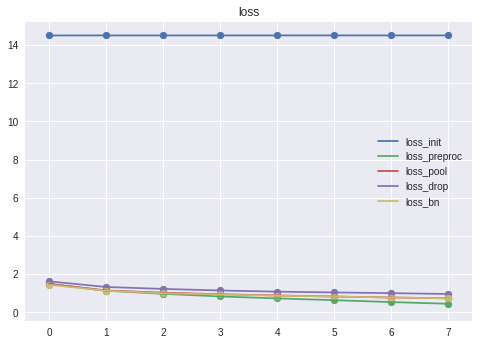

In [0]:
# Plot histories of all models
plotHistory(all_histories,['init','preproc','pool','drop','bn'],'loss')

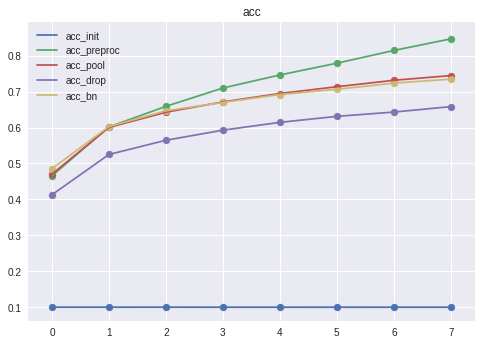

In [0]:
plotHistory(all_histories,['init','preproc','pool','drop','bn'],'acc')

#### Tensorboard 
We will be covering Tensorboard in Friday's tutorial. You can complete this part after the tutorial (21st Feb 2020)

You can run TensorBoard using the following command
```tensorboard --logdir=path/to/log-directory
```
Now for logs of all above trained models, take snapshot of the _loss_ and _accuracy_ plots and save in the directory where this notebook is. To show that saved plot here in notebook use following command in _markdown_ cell. 
<br> __![](path_to_image)__

In [0]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**Add cells to include loss plots**

In [0]:
import datetime

In [0]:
%tensorboard --logdir base_model

In [0]:
%tensorboard --logdir model_preprocessed_input

In [0]:
%tensorboard --logdir  model_pooling

In [0]:
%tensorboard --logdir  model_dropout

In [0]:
%tensorboard --logdir model_batch_normalized

##### Add your analysis here

# pre processed model is showing the best loss graph. as the lr is decreasing the model becomes better 

### Task 5.2 Visualize Activations
We will be covering this in Friday's tutorial. You can complete this part after the tutorial (21st Feb 2020). In this task, you are required to visualize the activations (outputs) of both the convolution layers of a model.

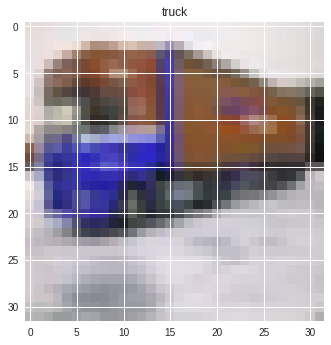

In [186]:
# Load any image here
testing= next(test)
image = testing[0][0]

plt.imshow(image)
plt.title(class_help[testing[1][0]])
plt.show()

In [0]:
plt.gca().grid(False);
test_reshaped = test_image.reshape((1,32,32,3))
# Get a prediction from ANY ONE of your models and output its label
activations = model_preprocessed.predict(test_reshaped)
classes_name[np.argmax(activations)]

In [0]:
# Create a Model from the Input layer to a Convolutional Layer
layer_outputs = model_preprocessed.layers[1].output
activation_model = Model(inputs=model_preprocessed.input, outputs=layer_outputs)

In [0]:
# Get a prediction for your chosen image using this model
predicted_activations = activation_model.predict(test_reshaped)

In [0]:
# Use your predictions to visualise the activations
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15), dpi=80)
for i,ax in enumerate(axes.flatten()):
    ax.imshow(predicted_activations[0,:,:,i],cmap='viridis');
    ax.grid(False);
    ax.axis('off');
plt.show()

In [0]:
# Create another model to visualize activations from ANOTHER convolutional layer
layer_outputs = model_preprocessed.layers[2].output
activation_model = Model(inputs=model_preprocessed.input, outputs=layer_outputs)

In [0]:
# You may rename this variable
second_predicted_activations = activation_model.predict(test_reshaped)

In [0]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15), dpi=80)
for i,ax in enumerate(axes.flatten()):
    ax.imshow(second_predicted_activations[0,:,:,i],cmap='viridis');
    ax.grid(False);
    ax.axis('off');

Q) What features from your chosen image do you think your model has been able to learn? In terms of filters (weights), what goes on when we add more convolutional layers in our models?
Ans: I think the  model is able to distinguish between boundraies clearily.

### Task 6.1  Effect of learning rate
Take the best selected model in __Task 5.1__ and change its learning rate to: 
- 6.1.1 any value between 5 and 1.
- 6.1.2 learning rate = any value between 0.6 and  0.1 
- 6.1.3 learning rate = 0.00001

and train these three models to compare the effect learning rate.

In [0]:
# pre processed model was the best
#using the lr given below and running the pre processed above
# lr = 4
#lr = 0.4
#lr = 0.00001

### Task 6.2 Plot loss and accuracy
Plot the loss and accracy for best model selected in task 5.1, and model trained in 6.1.1, 6.1.2 and 6.1.3 task. Give the detailed analysis of the effect of learning rate in your words and select the best learning rate for this problem.

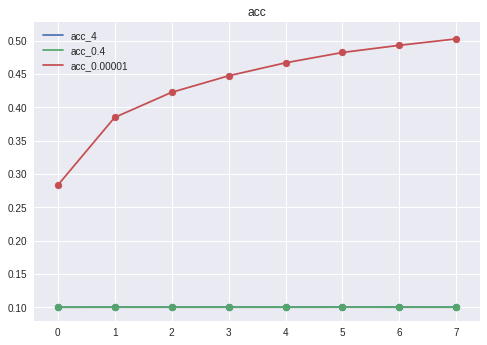

In [0]:
# Use plotHistory to make these plots
plotHistory(all_histories,['4','0.4','0.00001'],'acc')

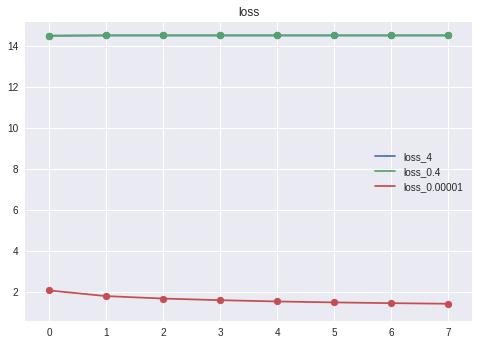

In [0]:
plotHistory(all_histories,['4','0.4','0.00001'],'loss')

Analysis: as the lr is decreasing the model is becoming  better